## I have some strange observations of the first roi not being a zero roi and it happeneing at different times. I want to see how prevelant this is and think about how I might acount for this 

In [57]:
from pathlib import Path
import pandas as pd

def _extract_adc_headers(hdr_path: Path):
    with open(hdr_path, "r") as f:
        for line in f:
            if line.startswith("ADCFileFormat:"):
                return [h.strip() for h in line.split(":", 1)[1].split(",")]
    raise ValueError(f"ADCFileFormat not found in header file: {hdr_path}")

def _read_adc_with_headers(adc_path: Path, hdr_path: Path) -> pd.DataFrame:
    headers = _extract_adc_headers(hdr_path)
    df = pd.read_csv(adc_path, header=None)
    df.columns = headers[:df.shape[1]]
    return df

def summarize_first_adc_row(data_dir: str) -> pd.DataFrame:
    data_dir = Path(data_dir)
    rows = []

    for hdr_path in sorted(data_dir.rglob("*.hdr")):
        adc_path = hdr_path.with_suffix(".adc")
        if not adc_path.exists():
            continue

        prefix = hdr_path.stem

        try:
            df = _read_adc_with_headers(adc_path, hdr_path)
            if df.empty:
                continue

            # Ensure required columns exist
            required = ["RunTime", "InhibitTime", "RoiX", "RoiY"]
            missing = [c for c in required if c not in df.columns]
            if missing:
                rows.append({
                    "file": prefix,
                    "first_RunTime": None,
                    "first_InhibitTime": None,
                    "first_RoiX": None,
                    "first_RoiY": None,
                    "roi_binary": None,
                    "note": f"missing columns: {missing}"
                })
                continue

            # Pull first row
            first = df.iloc[0]

            rt = pd.to_numeric(first["RunTime"], errors="coerce")
            inh = pd.to_numeric(first["InhibitTime"], errors="coerce")
            rx = pd.to_numeric(first["RoiX"], errors="coerce")
            ry = pd.to_numeric(first["RoiY"], errors="coerce")

            # zero ROI defined as RoiX==0 and RoiY==0
            roi_binary = None
            if pd.notna(rx) and pd.notna(ry):
                roi_binary = 0 if (rx == 0 and ry == 0) else 1

            rows.append({
                "file": prefix,
                "first_RunTime": rt,
                "first_InhibitTime": inh,
                "first_RoiX": rx,
                "first_RoiY": ry,
                "roi_binary": roi_binary,
                "note": ""
            })

        except Exception as e:
            rows.append({
                "file": prefix,
                "first_RunTime": None,
                "first_InhibitTime": None,
                "first_RoiX": None,
                "first_RoiY": None,
                "roi_binary": None,
                "note": f"error: {e}"
            })

    return pd.DataFrame(rows).sort_values("file").reset_index(drop=True)


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [59]:
df_first = summarize_first_adc_row("../IFCBData/DenseAlex/nauset/")
print(df_first)
#print(df_first[['first_RunTime' , 'roi_binary' ]])

                        file  first_RunTime  first_InhibitTime  first_RoiX  \
0   D20240402T001855_IFCB124       3.527602           0.077693       868.0   
1   D20240402T004255_IFCB124       3.900007           0.075558         0.0   
2   D20240402T010656_IFCB124       3.632984           0.075330       892.0   
3   D20240402T013056_IFCB124       3.837396           0.074123       596.0   
4   D20240402T015457_IFCB124       3.900831           0.071302       516.0   
5   D20240402T021857_IFCB124       4.367502           0.075063       780.0   
6   D20240402T024258_IFCB124       4.008507           0.074957       876.0   
7   D20240402T030659_IFCB124       4.129872           0.071918       716.0   
8   D20240402T033059_IFCB124       4.051226           0.073676       844.0   
9   D20240402T035500_IFCB124       4.226836           0.075720       572.0   
10  D20240402T041916_IFCB124       4.205801           0.071250         0.0   
11  D20240402T044316_IFCB124       4.271845           0.076921  

In [9]:
### Checking the above is correct can load in an adc file directly and compair first row
test = pd.read_csv('../IFCBData/DenseAlex/nauset/D20240402T064320_IFCB124.adc')
print(test.head())

   1  0.0605366  0.0018692017  0.044973493  0.0028192997  0.0050747395  \
0  2   4.408047      0.001517     0.012504      0.002854      0.004928   
1  3   4.503701      0.012657     0.084206      0.002866      0.005155   
2  4   4.621901      0.001503     0.003767      0.002772      0.004659   
3  5   4.758038      0.008116     0.009092      0.002800      0.004803   
4  6   5.157566      0.151186     0.733638      0.002952      0.005845   

   0.1294899  0.5991101  0.015001297  0.0186944  ...  0.1  0.2  0.3    0.4  \
0   0.031629   0.266523     0.014801   0.018516  ...  526   72   52      0   
1   0.201478   1.142721     0.015054   0.018790  ...  518  112   84   3744   
2   0.012944   0.149105     0.014791   0.018508  ...  638  112   84  13152   
3   0.134089   0.201278     0.014975   0.018668  ...  510   88   84  22560   
4   1.473861   3.507657     0.015190   0.018876  ...  358  184  172  29952   

   0.5  0.6  0.7  0.8  0.09454427083333333       0.9  
0    0    0    0    0          

In [51]:
## Some super basic stats about what first roi looks like 

N = len(df_first)
## how many zero rois total
n_zero = (df_first["roi_binary"] == 0).sum()
frac_zero = n_zero / N
print(f"total rois: {N}")
print(f"Zero ROIs: {n_zero} ({frac_zero:.3f})")

total rois: 56
Zero ROIs: 12 (0.214)


In [52]:
## How many have first entry over t = 0.1

mask_rt = df_first["first_RunTime"] > 0.1

n_rt = mask_rt.sum()
frac_rt = n_rt / N
n1_rt=N-n_rt

print(f"first_RunTime less than 0.1: {n1_rt}")
print(f"first_RunTime greater than 0.1 s: {n_rt} ({frac_rt:.3f})")


first_RunTime less than 0.1: 5
first_RunTime greater than 0.1 s: 51 (0.911)


In [53]:
mask_rt_zero = mask_rt & (df_first["roi_binary"] == 0)

n_rt_zero = mask_rt_zero.sum()
frac_rt_zero = n_rt_zero / n_rt if n_rt > 0 else float("nan")

print(f"Zero ROIs with first_RunTime > 0.1 s: {n_rt_zero} ({frac_rt_zero:.3f})")


Zero ROIs with first_RunTime > 0.1 s: 7 (0.137)


In [54]:
summary = pd.DataFrame({
    "metric": [
        "Zero ROIs",
        "first_RunTime > 0.1 s",
        "Zero ROIs | first_RunTime > 0.1 s"
    ],
    "count": [
        n_zero,
        n_rt,
        n_rt_zero
    ],
    "fraction total": [
        frac_zero,
        frac_rt,
        frac_rt_zero
    ]
})

print(summary)


                              metric  count  fraction total
0                          Zero ROIs     12        0.214286
1              first_RunTime > 0.1 s     51        0.910714
2  Zero ROIs | first_RunTime > 0.1 s      7        0.137255


In [ ]:
## Making sure that the inhibit time diff is computed correctly 

In [ ]:
# identify false trigger
false_mask = (df["RunTime"] < 0.25) & (df["RoiX"] == 0) & (df["RoiY"] == 0)

# drop it (could be 0 or 1 row, possibly more if you want to be extra safe)
df = df.loc[~false_mask].sort_values("RunTime").reset_index(drop=True)

# recompute InhibitTimeDiff from cumulative InhibitTime
df["InhibitTime"] = pd.to_numeric(df["InhibitTime"], errors="coerce")
df["InhibitTimeDiff"] = df["InhibitTime"].diff()
df.loc[0, "InhibitTimeDiff"] = df.loc[0, "InhibitTime"]


## Do zero rois have an inhibit time
Used a new merging function to get some files with just adc and should still have the zero rois included

In [60]:
import os
import pandas as pd
import numpy as np

def zero_roi_inhibit_times(data_dir: str) -> pd.Series:
    vals = []

    for fname in sorted(os.listdir(data_dir)):
        if not fname.lower().endswith(".csv"):
            continue

        df = pd.read_csv(os.path.join(data_dir, fname))

        required = {"RoiX", "RoiY", "InhibitTimeDiff"}
        if not required.issubset(df.columns):
            continue

        df["RoiX"] = pd.to_numeric(df["RoiX"], errors="coerce")
        df["RoiY"] = pd.to_numeric(df["RoiY"], errors="coerce")
        df["InhibitTimeDiff"] = pd.to_numeric(df["InhibitTimeDiff"], errors="coerce")

        zero_mask = (df["RoiX"] == 0) & (df["RoiY"] == 0)

        vals.append(df.loc[zero_mask, "InhibitTimeDiff"])

    if not vals:
        return pd.Series(dtype=float)

    return pd.concat(vals, ignore_index=True).dropna()


In [71]:
zero_inhibit_alex = zero_roi_inhibit_times("../IFCBData/DenseAlex/nauset/zeroRoiMerge/")
print(zero_inhibit_alex.describe())


count    431.000000
mean       0.086097
std        0.063252
min        0.010243
25%        0.080773
50%        0.081745
75%        0.082296
max        0.832031
Name: InhibitTimeDiff, dtype: float64


In [68]:
testdf = pd.read_csv("../IFCBData/CosmicData/mdibl/zeroRoiMerge/D20250822T162555_IFCB144_adc_only.csv")

In [69]:
print(testdf.head())

   RoiNumber   ADCtime   RunTime  InhibitTime  InhibitTimeDiff  \
0          1  5.668584  5.689711     0.071443         0.071443   
1          2  7.142178  7.162476     0.151406         0.079963   
2          3  7.329543  7.352070     0.233566         0.082159   
3          4  7.583151  7.603895     0.315599         0.082033   
4          5  9.128670  9.149178     0.397053         0.081454   

   VolumeAnalyzed  RoiHeight  RoiWidth  RoiX  RoiY  
0        0.023409         92       112   948   670  
1        0.029213         84       328   940   606  
2        0.029660         52        80   980   934  
3        0.030368          0         0     0     0  
4        0.036467         68        96   980   806  


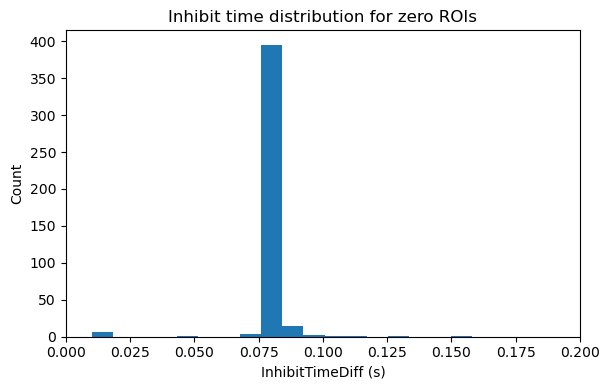

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(zero_inhibit_alex, bins=100)
plt.xlabel("InhibitTimeDiff (s)")
plt.ylabel("Count")
plt.title("Inhibit time distribution for zero ROIs")
plt.tight_layout()
plt.xlim(0,0.2)
#plt.savefig("../Figs/ZeroRoiInhibitTime.png")
plt.show()

In [77]:
#### Looks like yes so now with this new knowledge in hand I will reasses how to calculate inhibit time 